In [121]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time
from bs4 import BeautifulSoup 
import pandas as pd
import numpy as np
import re
import requests
from random import *
from tqdm import tqdm #progress bar
from datetime import datetime
import os
from os import listdir
import glob
import pickle #for saving data
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

In [122]:
def create_links_table(base_link = 'https://www.funda.nl/en/koop/heel-nederland/p', sleep_time = 3):

    chrome_options = webdriver.ChromeOptions()
    prefs = {"profile.managed_default_content_settings.images": 2} # this is to not load images
    chrome_options.add_experimental_option("prefs", prefs)

    #start a driver
    driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=chrome_options)
    driver.get(base_link + '1/')
    time.sleep(sleep_time)

    one_page_source = BeautifulSoup(driver.page_source, 'html.parser')

    try:
        pagination_list = one_page_source.find_all('div', {'class': 'pagination-pages'})
        pagination_list_a = pagination_list[0].find_all('a')
        
        pagination_list_a_len = len(pagination_list_a)
        paginattion_list_a_text = pagination_list_a[pagination_list_a_len-1].text
        
        #replace string
        paginattion_list_a_text = paginattion_list_a_text.replace(',', '')
        paginattion_list_a_text = paginattion_list_a_text.replace('.', '')
        
        #extract only numbers from the text
        paginattion_list_a_text_num = re.findall(r'\d+', paginattion_list_a_text)
        print('last page: ', paginattion_list_a_text_num[0])
        paginattion_list_a_text_num = int(paginattion_list_a_text_num[0])
    except:
        paginattion_list_a_text_num = 1
        

    links_table = pd.DataFrame(columns = ['link'])

    for i in range(1, paginattion_list_a_text_num + 1):
        one_link =  base_link+ str(i) + '/'
        links_table = links_table.append({'link': one_link}, ignore_index = True)
    
    driver.close()

    return(links_table)

In [123]:
base_link_table_all = create_links_table()



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-122-a4df54b192eb>:8: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=chrome_options)


last page:  2324


In [124]:
base_link_table_all

,link
0,https://www.funda.nl/en/koop/heel-nederland/p1/
1,https://www.funda.nl/en/koop/heel-nederland/p2/
2,https://www.funda.nl/en/koop/heel-nederland/p3/
3,https://www.funda.nl/en/koop/heel-nederland/p4/
4,https://www.funda.nl/en/koop/heel-nederland/p5/
...,...
2319,https://www.funda.nl/en/koop/heel-nederland/p2...
2320,https://www.funda.nl/en/koop/heel-nederland/p2...
2321,https://www.funda.nl/en/koop/heel-nederland/p2...
2322,https://www.funda.nl/en/koop/heel-nederland/p2...


In [125]:
base_link_table_all.columns

Index(['link'], dtype='object')

In [126]:
rotterdam_link_table_all = create_links_table(base_link = 'https://www.funda.nl/en/koop/rotterdam/p', sleep_time = 3)



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-122-a4df54b192eb>:8: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=chrome_options)


last page:  84


In [7]:
def get_links_one_page(one_link_page = 'https://www.funda.nl/en/koop/heel-nederland/p1/', sleep_time = 1):
    
    chrome_options = webdriver.ChromeOptions()
    prefs = {"profile.managed_default_content_settings.images": 2} # this is to not load images
    chrome_options.add_experimental_option("prefs", prefs)

    #start a driver
    driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=chrome_options)
    driver.get(one_link_page)
    time.sleep(sleep_time)

    one_page_source = BeautifulSoup(driver.page_source, 'html.parser')
    
    search_result_containers = one_page_source.find_all('div', {'class': 'search-result-content-inner'})
    
    links_one_page = []

    i = 1

    try:
        for search_result_container in search_result_containers:
            resultlist = search_result_container.find_all('a', {'data-object-url-tracking': 'resultlist'})
            resultlist_link = resultlist[0]['href']
            links_one_page.append(resultlist_link)
            i = i + 1
    except:
        pass

    driver.close()

    return(links_one_page)

In [8]:
def get_links_multiple_page(base_link_list = base_link_table_all['link'][:3], sleep_time_per_page = 1, save_to_csv = True):

    df = pd.DataFrame()

    for link in tqdm(base_link_list):

        links_one_page = get_links_one_page(one_link_page = link, sleep_time = sleep_time_per_page)

        #create a dataframe with a column
        df_links = pd.DataFrame(links_one_page, columns = ['ad_link'])
        df_links['page_link'] = link #via this we can see which make and model the links belong to
        #datetime string
        now = datetime.now() 
        datetime_string = str(now.strftime("%Y%m%d_%H%M%S"))
        df_links['link_download_date_time'] = datetime_string

        #save the dataframe if save_to_csv is True
        if save_to_csv:
            #check if folder exists and if not create it
            if not os.path.exists('data/ad_links'):
                os.makedirs('data/ad_links')

            df_links.to_csv(str('data/ad_links/links_on_one_page_df' + datetime_string + '.csv'), index = False)

        df = pd.concat([df, df_links], ignore_index=True)
    
     #drop duplicates
    df = df.drop_duplicates()

    return(df)


In [9]:
def get_buy_data(base_link = 'https://www.funda.nl/en/koop/rotterdam/p', sleep_time = 3, save_to_csv = True, max_len = 10):

    base_table = create_links_table(base_link = base_link, sleep_time = 3)

    # check if max_len is integer
    if isinstance(max_len, int):
        ads_link_data = get_links_multiple_page(base_link_list = base_table['link'][:max_len], save_to_csv=save_to_csv)
    elif max_len == 'all':
        ads_link_data = get_links_multiple_page(base_link_list = base_table['link'], save_to_csv=save_to_csv)
    else:
        add_link_data = "max_len is not an integer or 'all'"

    return(ads_link_data)   
    

In [10]:
#rotterdam_link_data = get_buy_data(max_len = 10)

In [11]:
#rotterdam_link_data

# Combine files in one folder

In [12]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [13]:
# concatenate the dataframes in one folder to get one file (with different columns)
def concatenate_dfs(indir = "data/ad_links", filename_to_save = 'ad_links', save_to_csv = True,  save_to_pickle = True, keep_only_latest = True, keep_only_latest_date_column = 'link_download_date_time'):
    

    fileList = find_csv_filenames(path_to_dir = indir)
    print("Found this many CSVs: ", len(fileList), " In this folder: ", str(os.getcwd()) + "/" + str(indir))

    # add string to every element in the fileList
    fileList = [indir + "/" + filename for filename in fileList]

    output_file = pd.concat([pd.read_csv(filename) for filename in fileList], ignore_index=True)

    if keep_only_latest:
        output_file_latest = output_file.groupby(['ad_link'], dropna=False).agg(number_of_ads=('ad_link', 'count'), latest_scrape=(keep_only_latest_date_column, 'max'))
        output_file_latest = output_file_latest.reset_index()
        
        output_file = pd.merge(output_file, output_file_latest[['ad_link', 'latest_scrape']], how = 'left', left_on = ['ad_link'], right_on = ['ad_link'])
        output_file = output_file.reset_index(drop=True)
        # keep rows where download_date_time is equal to latest_scrape
        output_file = output_file[output_file[keep_only_latest_date_column] == output_file['latest_scrape']]
        output_file = output_file.reset_index(drop=True)
        # drop the latest_scrape column
        output_file = output_file.drop(columns = ['latest_scrape'])

    if save_to_csv:
        output_file.to_csv("data/" + filename_to_save + ".csv", index=False)

    if save_to_pickle:
        output_file.to_pickle("data/" + filename_to_save + ".pkl")

    return(output_file)

In [14]:
all_files = concatenate_dfs(indir = "data/ad_links", save_to_csv = True, filename_to_save = 'ad_links', save_to_pickle = True, keep_only_latest=True)

Found this many CSVs:  94  In this folder:  c:\Users\menyh\Documents\funda/data/ad_links


In [15]:
all_files

,ad_link,page_link,link_download_date_time
0,https://www.funda.nl/en/koop/rotterdam/huis-42...,https://www.funda.nl/en/koop/rotterdam/p2/,20220124_234329
1,https://www.funda.nl/en/koop/rotterdam/apparte...,https://www.funda.nl/en/koop/rotterdam/p4/,20220124_234345
2,https://www.funda.nl/en/koop/rotterdam/huis-42...,https://www.funda.nl/en/koop/rotterdam/p10/,20220124_234458
3,https://www.funda.nl/en/koop/rotterdam/huis-88...,https://www.funda.nl/en/koop/rotterdam/p10/,20220124_234458
4,https://www.funda.nl/en/koop/rotterdam/apparte...,https://www.funda.nl/en/koop/rotterdam/p11/,20220124_234507
...,...,...,...
1246,https://www.funda.nl/en/koop/rotterdam/huis-42...,https://www.funda.nl/en/koop/rotterdam/p10/,20220125_134714
1247,https://www.funda.nl/en/koop/rotterdam/huis-42...,https://www.funda.nl/en/koop/rotterdam/p10/,20220125_134714
1248,https://www.funda.nl/en/koop/rotterdam/huis-42...,https://www.funda.nl/en/koop/rotterdam/p10/,20220125_134714
1249,https://www.funda.nl/en/koop/rotterdam/huis-42...,https://www.funda.nl/en/koop/rotterdam/p10/,20220125_134714


In [16]:
all_files.columns

Index(['ad_link', 'page_link', 'link_download_date_time'], dtype='object')

In [17]:
all_files['ad_link'][0]

'https://www.funda.nl/en/koop/rotterdam/huis-42548338-ben-websterstraat-16/?navigateSource=resultlist'

# Scrape each ad_link

In [18]:
def get_data_for_one_link(ad_link, sleep_time = 3):

    chrome_options = webdriver.ChromeOptions()
    prefs = {"profile.managed_default_content_settings.images": 2} # this is to not load images
    chrome_options.add_experimental_option("prefs", prefs)

    #start a driver
    driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=chrome_options)
    driver.get(ad_link)
    time.sleep(sleep_time)

    one_page_source = BeautifulSoup(driver.page_source, 'html.parser')

    driver.quit()

    #create a dataframe
    df_1 = pd.DataFrame()
    df_2 = pd.DataFrame()

    header_title_list = []
    header_subtitle_list = []

    ad_columnname_list = []
    ad_value_list = []
    
    try:
        header_title = one_page_source.find('span', {'class': 'object-header__title'})
        header_title_list.append(header_title.text)
    except:
        header_title_list.append(np.nan)

    try:
        header_subtitle = one_page_source.find('span', {'class': re.compile('^object-header__subtitle')})
        #replace /n with nothing
        header_subtitle_text = header_subtitle.text.replace('\n', '')
        header_subtitle_list.append(header_subtitle_text)
    except:
        header_subtitle_list.append(np.nan)

    try:
        list_of_objects_broad = one_page_source.find('div', {'class': 'object-kenmerken-body'})

        list_of_objects_dt = list_of_objects_broad.find_all('dt')
        i = 0
        for dt in list_of_objects_dt:
            i = i + 1
            ad_columnname_list.append(dt.text.replace('\n', ''))

        list_of_objects_dd = list_of_objects_broad.find_all('dd')
        i = 0
        for dd in list_of_objects_dd:
            i = i + 1
            ad_value_list.append(dd.text.replace('\n', ''))

        #exceptions:
        try:
            area_position = ad_columnname_list.index("Areas")
            del ad_value_list[area_position]
        except:
            pass

        try:
            cadastral_position = ad_value_list.index("Cadastral map")
            del ad_value_list[cadastral_position]
            del ad_columnname_list[cadastral_position]
            del ad_value_list[cadastral_position]
        except:
            pass

        ad_columnname_list.append('error')
        ad_value_list.append('no')

    except:
        ad_columnname_list.append('error')
        ad_value_list.append('yes')



    # add header_title to dataframe
    
    df_1['header_title'] = header_title_list
    df_1['header_subtitle'] = header_subtitle_list
    df_1['ad_link'] = ad_link
     
    #datetime string
    now = datetime.now() 
    datetime_string = str(now.strftime("%Y%m%d_%H%M%S"))
    df_1['ad_download_date_time'] = datetime_string

    ad_columnname_list.append("ad_link")
    ad_value_list.append(ad_link)

    df_2 = pd.DataFrame([ad_value_list], columns = ad_columnname_list)

    df_1 = df_1.reset_index(drop=True)
    df_2 = df_2.reset_index(drop=True)

    #left join df_1 and df2
    df = pd.merge(df_1, df_2, how = 'left', left_on = ['ad_link'], right_on = ['ad_link'])

    df = df.reset_index(drop=True)

    cols=pd.Series(df.columns)
    for dup in df.columns[df.columns.duplicated(keep=False)]: 
        cols[df.columns.get_loc(dup)] = ([dup + '.' + str(d_idx) if d_idx != 0 else dup for d_idx in range(df.columns.get_loc(dup).sum())])
    
    df.columns=cols
    

    return(df)


In [19]:
data = get_data_for_one_link(ad_link = 'https://www.funda.nl/en/koop/rotterdam/huis-42548338-ben-websterstraat-16/?navigateSource=resultlist')



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-18-60c9d03b8675>:8: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=chrome_options)


In [20]:
data

,header_title,header_subtitle,ad_link,ad_download_date_time,Asking price,Asking price per m²,Listed since,Status,Acceptance,Kind of house,...,Ownership situation,Location,Garden,Front garden,Garden location,Shed / storage,Facilities.1,Insulation.1,Type of parking facilities,error
0,Ben Websterstraat 16,3069 XJ Rotterdam,https://www.funda.nl/en/koop/rotterdam/huis-42...,20220125_214948,"€ 400,000 kosten koper","€ 3,279 The asking price per m² (€ 400,000)...",7 weeks,Sold under reservation,Available in consultation,"Single-family home, corner house (kwadrant won...",...,Full ownership,Sheltered location and in residential district,Front garden and side garden,72 m² (6 meter deep and 12 meter broad),Located at the west,Detached wooden storage,Electricity,No insulation,Public parking,no


In [21]:
data.columns

Index(['header_title', 'header_subtitle', 'ad_link', 'ad_download_date_time',
       'Asking price', '    Asking price per m²', 'Listed since', 'Status',
       'Acceptance', 'Kind of house', 'Building type', 'Year of construction',
       'Accessibility', 'Specific', 'Type of roof', 'Areas', 'Living area',
       'External storage space', 'Plot size', 'Volume in cubic meters',
       'Number of rooms', 'Number of bath rooms', 'Bathroom facilities',
       'Number of stories', 'Facilities', 'Energy label', 'Insulation',
       'Heating', 'Hot water', 'Area', 'Ownership situation', 'Location',
       'Garden', 'Front garden', 'Garden location', 'Shed / storage',
       'Facilities.1', 'Insulation.1', 'Type of parking facilities', 'error'],
      dtype='object')

In [118]:
# read in pickle file
ad_data_all = pd.read_pickle("data/ad_data.pkl")
ad_data_all_ad_link_list = ad_data_all['ad_link']
print(len(ad_data_all_ad_link_list))

1144


In [119]:
def get_data_for_multiple_links(ad_links = all_files['ad_link'][:10], sleep_time_per_page = 1, save_to_csv = True, check_this_list = ad_data_all_ad_link_list):

    #get list elements that are not in check_this_list but in ad_links

    links_to_scrape = set(ad_links) - set(check_this_list)
    print("scraping these many links:", len(links_to_scrape))

    df = pd.DataFrame()

    error_link = []

    for link in tqdm(links_to_scrape):           
        
        try:
            one_ad_data = get_data_for_one_link(ad_link = link, sleep_time = sleep_time_per_page)

            if save_to_csv:
                #check if folder exists and if not create it
                if not os.path.exists('data/ad_data'):
                    os.makedirs('data/ad_data')

                #datetime string
                now = datetime.now() 
                datetime_string = str(now.strftime("%Y%m%d_%H%M%S"))

                one_ad_data.to_csv(str('data/ad_data/ad_data' + datetime_string + '.csv'), index = False)

            one_ad_data = one_ad_data.reset_index(drop=True)
            df = df.reset_index(drop=True)

            df = pd.concat([df, one_ad_data], ignore_index=True)
        
        except:
            error_link.append(link)            
            continue
    
    df = df.reset_index(drop=True)
    #drop duplicates
    df = df.drop_duplicates()

    print("got error in these links:")
    print(error_link)

    if len(error_link) > 0:
        if not os.path.exists('data/logs/error_ad_download'):
            os.makedirs('data/logs/error_ad_download')

        #datetime string
        now = datetime.now() 
        datetime_string = str(now.strftime("%Y%m%d_%H%M%S"))

        #create pandas dataframe with error links
        error_link_df = pd.DataFrame(error_link, columns = ['error_link'])
        error_link_df.to_csv(str('data/logs/error_ad_download' + datetime_string + '.csv'), index = False)

    return(df)

In [120]:
all_ads_data = get_data_for_multiple_links(ad_links = all_files['ad_link'], sleep_time_per_page = 1, save_to_csv = True)

  0%|          | 0/107 [00:00<?, ?it/s]

====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache


scraping these many links: 107


<ipython-input-18-60c9d03b8675>:8: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=chrome_options)
  1%|          | 1/107 [00:08<14:50,  8.41s/it]

====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
  2%|▏         | 2/107 [00:16<14:23,  8.22s/it]

====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
  3%|▎         | 3/107 [00:24<14:19,  8.27s/it]

====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST driver version for 97.0.4692
Driver [C:\Users\menyh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
  4%|▎         | 4/1

got error in these links:
['https://www.funda.nl/en/koop/rotterdam/appartement-42513429-harddraverstraat-45-a1/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/huis-42675287-noorder-kerkedijk-35-a/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/huis-88012807-rhederoord-2/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/bouwgrond-41376219-grindweg/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/appartement-42449371-sicilieboulevard-548/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/appartement-42682491-wijnkade-80/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/bouwgrond-41376218-grindweg/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/appartement-42502291-maashaven-nz-545/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/huis-88042182-karl-marxstraat-15/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/ap

In [35]:
#all_ads_data

In [105]:
all_ads_data.shape

(384, 79)

In [106]:
all_ads_data.columns

Index(['header_title', 'header_subtitle', 'ad_link', 'ad_download_date_time',
       'Asking price', '    Asking price per m²', 'Listed since', 'Status',
       'Acceptance', 'VVE (Owners Association) contribution', 'Type apartment',
       'Building type', 'Year of construction', 'Type of roof', 'Areas',
       'Living area', 'Exterior space attached to the building',
       'External storage space', 'Volume in cubic meters', 'Number of rooms',
       'Number of bath rooms', 'Bathroom facilities', 'Number of stories',
       'Located at', 'Energy label', 'Heating', 'Hot water', 'CH boiler',
       'Ownership situation', 'Location', 'Balcony/roof garden',
       'Shed / storage', 'Type of parking facilities', 'Registration with KvK',
       'Annual meeting', 'Periodic contribution', 'Reserve fund present',
       'Maintenance plan', 'Building insurance', 'error', 'Kind of house',
       'Specific', 'Quality marks', 'Facilities', 'Insulation',
       'Ownership situation.1', 'Garden', '

In [127]:
all_ads_data = concatenate_dfs(indir = "data/ad_data", filename_to_save = 'ad_data', save_to_csv = True,  save_to_pickle = True, keep_only_latest=True, keep_only_latest_date_column='ad_download_date_time')

Found this many CSVs:  1222  In this folder:  c:\Users\menyh\Documents\funda/data/ad_data


In [128]:
all_ads_data.shape

(1196, 81)

# Data Cleaning

In [129]:
all_ads_data.columns

Index(['header_title', 'header_subtitle', 'ad_link', 'ad_download_date_time',
       'Asking price', '    Asking price per m²', 'Listed since', 'Status',
       'Acceptance', 'Kind of house', 'Building type', 'Year of construction',
       'Accessibility', 'Specific', 'Type of roof', 'Areas', 'Living area',
       'External storage space', 'Plot size', 'Volume in cubic meters',
       'Number of rooms', 'Number of bath rooms', 'Bathroom facilities',
       'Number of stories', 'Facilities', 'Energy label', 'Insulation',
       'Heating', 'Hot water', 'Area', 'Ownership situation', 'Location',
       'Garden', 'Front garden', 'Garden location', 'Shed / storage',
       'Facilities.1', 'Insulation.1', 'Type of parking facilities', 'error',
       'VVE (Owners Association) contribution', 'Type apartment',
       'Exterior space attached to the building', 'Located at',
       'Balcony/roof garden', 'Registration with KvK', 'Annual meeting',
       'Periodic contribution', 'Reserve fund pre

In [130]:
def clean_data(data):
    data['price'] = data['Asking price'].str.replace('.', '')
    data['price'] = data['price'].str.replace(',', '')
    data['price'] = data['price'].str.extract('(\d+)').astype(int, errors='ignore')

    data = data[~data['price'].isna()]
    data['price'] = data['price'].astype(int)

    data['livingArea'] = data['Living area'].str.replace('.', '')
    data['livingArea'] = data['livingArea'].str.replace(',', '')
    data['livingArea'] = data['livingArea'].str.extract('(\d+)').astype(int, errors='ignore')

    data = data[~data['livingArea'].isna()]
    data['livingArea'] = data['livingArea'].astype(int)

    data['sqm_price'] = data['price'] / data['livingArea']
    #round to 2 decimals
    data['sqm_price'] =  data['sqm_price'].round(0)

    return(data)


In [131]:
data_clean = clean_data(all_ads_data)

<ipython-input-130-58479e4333b9>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['price'] = data['Asking price'].str.replace('.', '')
<ipython-input-130-58479e4333b9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['price'].astype(int)
<ipython-input-130-58479e4333b9>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['livingArea'] = data['Living area'].str.replace('.', '')
<ipython-input-130-58479e4333b9>:9

In [132]:
data_clean[['Asking price', 'Living area','price', 'livingArea', 'sqm_price']]

,Asking price,Living area,price,livingArea,sqm_price
0,"€ 400,000 kosten koper",122 m²,400000,122,3279.0
1,"€ 450,000 kosten koper",149 m²,450000,149,3020.0
2,"€ 650,000 kosten koper",171 m²,650000,171,3801.0
3,"€ 525,000 kosten koper",147 m²,525000,147,3571.0
4,"€ 295,000 kosten koper",82 m²,295000,82,3598.0
...,...,...,...,...,...
1191,"€ 725,000 kosten koper",137 m²,725000,137,5292.0
1192,"€ 625,000 kosten koper",186 m²,625000,186,3360.0
1193,"€ 500,000 kosten koper",106 m²,500000,106,4717.0
1194,"€ 335,000 kosten koper",100 m²,335000,100,3350.0


<AxesSubplot:xlabel='sqm_price', ylabel='Count'>

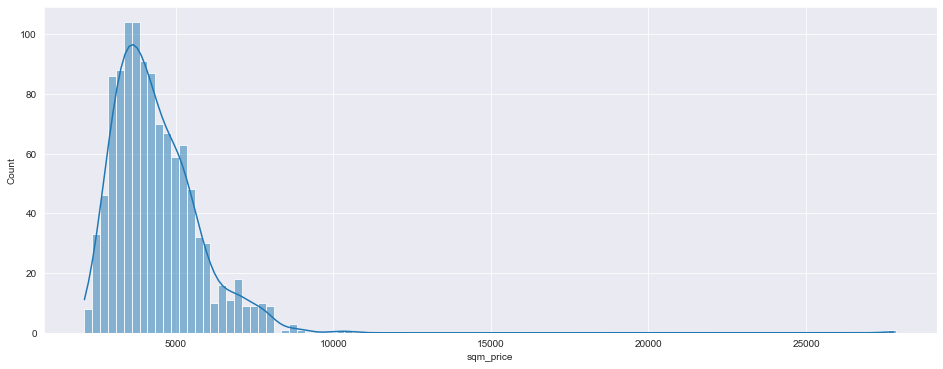

In [136]:
plt.figure(figsize=(16, 6))
sns.histplot(data=data_clean, x="sqm_price", binwidth=250, kde = True)

In [134]:
inspect_data = data_clean[['header_title', 'header_subtitle', 'ad_link', 'Asking price', 'Living area','price', 'livingArea', 'sqm_price']]
inspect_data = inspect_data[inspect_data['sqm_price'] > 10000]

print(inspect_data['ad_link'].tolist())

['https://www.funda.nl/en/koop/rotterdam/huis-88871705-straatweg-127/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/huis-42680992-plasoord-27/?navigateSource=resultlist', 'https://www.funda.nl/en/koop/rotterdam/appartement-88970171-boompjes-666/?navigateSource=resultlist']


<AxesSubplot:xlabel='sqm_price', ylabel='Count'>

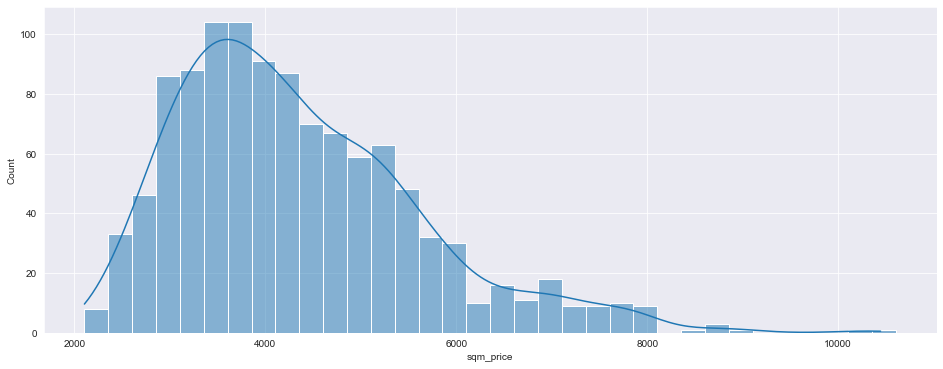

In [135]:
plt.figure(figsize=(16, 6))
sns.histplot(data=data_clean[data_clean['sqm_price'] < 15000], x="sqm_price", binwidth=250, kde = True)